In [2]:
import os, sys, argparse, importlib, time
import numpy as np
import matplotlib.pyplot as plt
import os.path as osp
from tensorflow.python.ops.math_ops import reduce_euclidean_norm
from sklearn.preprocessing import normalize
from importlib import reload
from tqdm import tqdm

import wandb 


file_path=os.getcwd()
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
import tensorflow_probability as tfp

gpu_devices = tf.config.list_physical_devices('GPU') 
if len(gpu_devices) > 0:
    print("GPU detected")
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import load_model


from spektral.data import DisjointLoader

# file_path = osp.dirname(osp.realpath(__file__))

################################################
# Setup Deafult Variabls                       # 
################################################
learning_rate = 5e-4
batch_size    = 512
epochs        = 100
early_stop    = True
patience      = 5
log_wandb     = False
model_name    = "GCN_Schauser_doptimized"


################################################
# Setup Hyperparameters                        # 
################################################
hidden_states = 128
forward       = False
dropout       = 0.5
loss_method   = "loss_func_linear_angle"
n_neighbors   = 6 # SKRIV SELV IND



if log_wandb:
    wandb.init(project="icecube", entity="johannbs")
    # Declare for log
    wandb.config.hidden_states = hidden_states
    wandb.config.forward = forward
    wandb.config.dropout = dropout
    wandb.config.learning_rate = learning_rate
    wandb.config.batch_size = batch_size
    wandb.config.loss_func = loss_method
    wandb.config.n_neighbors = n_neighbors



################################################
# Get model and data                           # 
################################################
from models.GCN_johann import model
model = model(n_out=7)
# model = load_model(osp.join(file_path, "models", "saved_models", "MessPass1"))



import data_load as dl
reload(dl)
graph_data=dl.graph_data
dataset=graph_data(n_data=1e5, restart=1, pos=1)
idx_lists = dataset.index_lists
# Split data
dataset_train = dataset[idx_lists[0]]
dataset_val   = dataset[idx_lists[1]]
dataset_test  = dataset[idx_lists[2]]

loader_train = DisjointLoader(dataset_train, epochs=epochs, batch_size=batch_size) # the different loaders work very very differently, beware
loader_test = DisjointLoader(dataset_test, batch_size=batch_size, epochs=1)

# save_path     = osp.join(file_path, "models", "saved_models", model_name)
# if not os.path.exists(save_path):
#     os.mkdir(save_path)

################################################
# Loss and Optimation                          # 
################################################
# import loss_functions

def loss_func_linear_angle(y_reco, y_true, return_from = False):
    # Energy loss
    loss_energy    = tf.reduce_mean(
        tf.abs(
            tf.subtract(
                y_reco[:,0], y_true[:,0]
                )
            )
        )
    loss           = loss_energy

    # Position loss
    loss_dist  = tf.reduce_mean(
        tf.sqrt(
            tf.reduce_sum(
                tf.square(
                    tf.subtract(
                        y_reco[:, 1:4], y_true[:, 1:4]
                    )
                ), axis = 1
            )
        )
    )
    loss       += loss_dist

    cos_angle = tf.math.divide_no_nan(tf.reduce_sum(y_reco[:, 4:] * y_true[:, 4:], axis = 1),
            tf.math.reduce_euclidean_norm(y_reco[:, 4:], axis = 1) * tf.math.reduce_euclidean_norm(y_true[:, 4:],  axis = 1))

    cos_angle -= tf.math.sign(cos_angle) * 1e-6
    loss_angle = tf.reduce_mean(tf.math.acos(cos_angle))

    loss       += loss_angle
    
    
    if return_from:
        return float(loss_energy), float(loss_dist), float(loss_angle)
    else:
        return loss
    
loss_func=loss_func_linear_angle

opt           = Adam(learning_rate = learning_rate)
mse           = MeanSquaredError()

def angle(pred, true):
    return tf.math.acos(
        tf.clip_by_value(
            tf.math.divide_no_nan(tf.reduce_sum(pred * true, axis = 1),
            tf.math.reduce_euclidean_norm(pred, axis = 1) * tf.math.reduce_euclidean_norm(true,  axis = 1)),
            -1., 1.)
        )

def negative_cos(pred, true):
    return 1 - tf.math.divide_no_nan(tf.reduce_sum(pred * true, axis = 1),
            tf.math.reduce_euclidean_norm(pred, axis = 1) * tf.math.reduce_euclidean_norm(true,  axis = 1))

def metrics(y_reco, y_true):
    # Energy metric
    energy_residuals = y_true[:, 0] - y_reco[:, 0]
    energy_quantiles = tfp.stats.percentile(energy_residuals, [25, 75])
    w_energy         = (energy_quantiles[1] - energy_quantiles[0]) / 1.349


    # Distanc metric
    dist_resi  = tf.sqrt(
            tf.reduce_sum(
                tf.square(
                    tf.subtract(
                        y_reco[:, 1:4], y_true[:, 1:4]
                    )
                ), axis = 1
            )
        )
    u_pos           = tfp.stats.percentile(dist_resi, [68])


    # Angle metric
    angle_resi = 180 / np.pi * angle(y_reco[:, 4:], y_true[:, 4:])

    u_angle         = tfp.stats.percentile(angle_resi, [68])

    return float(w_energy.numpy()), float(u_pos.numpy()), float(u_angle.numpy())

def lr_schedule(epochs = epochs, initial = learning_rate, decay = 0.9):
    n = 1
    lr = initial
    yield lr
    while n < 3:
        lr *= 2
        n  += 1
        yield lr
    while True:
        lr *= decay
        n  += 1 
        yield lr

        


################################################
# TF - functions                               # 
################################################

@tf.function(input_signature = loader_train.tf_signature(), experimental_relax_shapes = True)
def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training = True)
        targets     = tf.cast(targets, tf.float32)
        loss        = loss_func(predictions, targets)
        loss       += sum(model.losses)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    return loss




@tf.function(input_signature = loader_test.tf_signature(), experimental_relax_shapes = True)
def test_step(inputs, targets):
    predictions = model(inputs, training = False)
    targets     = tf.cast(targets, tf.float32) 
    out         = loss_func(predictions, targets)

    return predictions, targets, out


def validation(loader):
    loss = 0
    prediction_list, target_list = [], []
    for batch in loader:
        inputs, targets = batch
#         inputs[0][:, :3] = inputs[0][:, :3] / 1000
        targets[:, 1:4] = targets[:, 1:4] / 1000
        predictions, targets, out = test_step(inputs, targets)
        loss           += out
        
        prediction_list.append(predictions)
        target_list.append(targets)
    
    y_reco  = tf.concat(prediction_list, axis = 0)
    y_true  = tf.concat(target_list, axis = 0)
    y_true  = tf.cast(y_true, tf.float32)

    w_energy, u_pos, u_angle = metrics(y_reco, y_true)
    l_energy, l_pos, l_angle = loss_func(y_reco, y_true, return_from = True)
    loss                     = loss_func(y_reco, y_true)

    return loss, [l_energy, l_pos, l_angle], [w_energy, u_pos, u_angle]


def test(loader):
    loss = 0
    prediction_list, target_list = [], []
    for batch in loader:
        inputs, targets = batch
#         inputs[0][:, :3] = inputs[0][:, :3] / 1000
        targets[:, 1:4] = targets[:, 1:4] / 1000
        predictions, targets, out = test_step(inputs, targets)
        loss           += out
        
        prediction_list.append(predictions)
        target_list.append(targets)

    y_reco  = tf.concat(prediction_list, axis = 0).numpy()
    y_true  = tf.concat(target_list, axis = 0)
    y_true  = tf.cast(y_true, tf.float32).numpy()


    # Unit vects to angles
    reco_vects = normalize(y_reco[:, 4:])    
    true_vects = normalize(y_true[:, 4:])


    reco_azi   = np.arctan2(reco_vects[:, 1], reco_vects[:, 0])
    reco_zen   = np.arctan2(reco_vects[:, 2], np.sqrt((reco_vects[:, :2] ** 2).sum(1)))

    true_azi   = np.arctan2(true_vects[:, 1], true_vects[:, 0])
    true_zen   = np.arctan2(true_vects[:, 2], np.sqrt((true_vects[:, :2] ** 2).sum(1)))





    energy = y_true[:, 0]
    counts, bins = np.histogram(energy, bins = 10)

    xs = (bins[1:] + bins[: -1]) / 2

    w_energies, u_distances, u_angles = [], [], []

    for i in range(len(bins)-1):
        idx = np.logical_and(energy > bins[i], energy < bins[i + 1])

        w, u_dist, u_angle = metrics(y_true[idx, :], y_reco[idx, :])

        w_energies.append(w)
        u_distances.append(u_dist)
        u_angles.append(u_angle)


    fig, ax = plt.subplots(ncols = 3, nrows = 3, figsize = (12, 12))

    for a in ax[0]:
        a_ = a.twinx()
        a_.step(xs, counts, color = "gray", zorder = 10, alpha = 0.7, where = "mid")
        a_.set_yscale("log")
        a.set_xlabel("Log Energy")
    
    ax_top = ax[0]

    # Energy reconstruction
    ax_top[0].scatter(xs, w_energies)
    ax_top[0].set_title("Energy Performance")
    ax_top[0].set_ylabel(r"$w(\Delta log(E)$")


    # Angle reconstruction
    ax_top[1].scatter(xs, u_angles)
    ax_top[1].set_title("Angle Performance")
    ax_top[1].set_ylabel(r"$u(\Delta \Omega)$")

    # Distance reconstruction
    ax_top[2].scatter(xs, u_distances)
    ax_top[2].set_title("Distance Performance")
    ax_top[2].set_ylabel(r"$u(||y_{reco} - y_{true}||)$")


    # truth - pred plots
    ax_mid = ax[1]

    # Energy
    ax_mid[0].set_title("Energy")
    ax_mid[0].plot(y_true[:, 0], y_reco[:, 0], 'b.', alpha = 0.25)


    # Zenith
    ax_mid[1].set_title("Zenith angle")
    ax_mid[1].plot(true_zen, reco_zen, 'b.', alpha = 0.25)
    

    # Azimuthal
    ax_mid[2].set_title("Azimuthal angle")
    ax_mid[2].plot(true_azi, reco_azi, 'b.', alpha = 0.25)





    # Histogram of guesses
    ax_bot = ax[2]

    # Energy
    ax_bot[0].set_title("Energy")
    ax_bot[0].hist(y_reco[:, 0] - y_true[:, 0], label = "reco - true", histtype = "step", bins = 50)
    ax_bot[0].hist(y_reco[:, 0], label = "reco", histtype = "step", bins = 50)
    ax_bot[0].hist(y_true[:, 0], label = "true", histtype = "step", bins = 50)

    # Zenith
    ax_bot[1].set_title("Zenith angle")
    ax_bot[1].hist(reco_zen - true_zen, label = "reco - true", histtype = "step", bins = 50)
    ax_bot[1].hist(reco_zen, label = "reco", histtype = "step", bins = 50)
    ax_bot[1].hist(true_zen, label = "true", histtype = "step", bins = 50)

    # Azimuthal
    ax_bot[2].set_title("Azimuthal angle")
    ax_bot[2].hist(reco_azi - true_azi, label = "reco - true", histtype = "step", bins = 50)
    ax_bot[2].hist(reco_azi, label = "reco", histtype = "step", bins = 50)
    ax_bot[2].hist(true_azi, label = "true", histtype = "step", bins = 50)
    ax_bot[2].legend()

    fig.tight_layout()

    return fig, ax


################################################
# Training                                     # 
################################################

current_batch = 0
current_epoch = 1
loss          = 0
lowest_loss   = 9999999
early_stop_counter    = 0

pbar          = tqdm(total = loader_train.steps_per_epoch, position = 0, leave = True)
start_time    = time.time()
lr_gen        = lr_schedule()
learning_rate = next(lr_gen)


for batch in loader_train:
    inputs, targets = batch
#     inputs[0][:, :3] = inputs[0][:, :3] / 1000
    targets[:, 1:4] = targets[:, 1:4] / 1000
    out             = train_step(inputs, targets)
    loss           += out

    current_batch  += 1
    pbar.update(1)
    pbar.set_description(f"Epoch {current_epoch} / {epochs}; Avg_loss: {loss / current_batch:.6f}")


    if current_batch == loader_train.steps_per_epoch:
        
        print(f"Epoch {current_epoch} of {epochs} done in {time.time() - start_time:.2f} seconds using learning rate: {learning_rate:.2E}")
        print(f"Avg loss of train: {loss / loader_train.steps_per_epoch:.6f}")

        loader_val    = DisjointLoader(dataset_val, epochs = 1,      batch_size = batch_size)
        val_loss, val_loss_from, val_metric = validation(loader_val)

        print(f"Avg loss of validation: {val_loss:.6f}")
        print(f"Loss from:  Energy: {val_loss_from[0]:.6f} \t Position: {val_loss_from[1]:.6f} \t Angle: {val_loss_from[2]:.6f} ")
        print(f"Energy: w = {val_metric[0]:.6f} \t Position: u = {val_metric[1]:.6f} \t Angle: u = {val_metric[2]:.6f}")

        if log_wandb:
            wandb.log({"Train Loss":      loss / loader_train.steps_per_epoch,
                    "Validation Loss": val_loss, 
                    "Energy metric":   val_metric[0],
                    "Position metric": val_metric[1],
                    "Angle metric":    val_metric[2],
                    "Learning rate":   learning_rate})


        if val_loss < lowest_loss:
            early_stop_counter = 0
            lowest_loss        = val_loss
        else:
            early_stop_counter += 1
        
        if early_stop and (early_stop_counter >= patience):
#             model.save(save_path)
            print(f"Stopped training. No improvement was seen in {patience} epochs")
            break

        if current_epoch != epochs:
            pbar.n            = 0
            pbar.last_print_n = 0
            pbar.refresh()

        learning_rate = next(lr_gen)
        opt.learning_rate.assign(learning_rate)

        if current_epoch % 10 == 0:
#             model.save(save_path)
            print("Model saved")

        loss            = 0
        start_time      = time.time()
        current_epoch  += 1
        current_batch   = 0

        
fig, ax = test(loader_test)
fig.savefig(f"model_tests/{model_name}_test.pdf")

GPU detected
Removed and ready to reload
Connecting to db-file
Loading Muons
Reading files


C:\Users\chris\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator RobustScaler from version 0.19.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


Splitting data to events
     dom_x    dom_y    dom_z      time  charge_log10
0 -0.25614 -0.52108  0.29178 -0.902557     -0.088028
1  0.50527  0.25788 -0.20864 -1.099296      0.378965
2 -0.06670  0.27692  0.00422  0.424602      0.791982
3  0.30341  0.33564  0.03637 -0.125602      1.160970
4  0.30341  0.33564  0.03637 -0.114116     -1.656923
   energy_log10  position_x  position_y  position_z  direction_x  direction_y  \
0      2.422178   17.395869  799.810842 -190.892722    -0.449283    -0.652320   
1      2.311812  753.894477 -267.662321 -255.052898    -0.865731     0.296605   
2      3.433424 -778.158990  185.657174 -176.742064     0.880773    -0.310683   
3      2.582473  174.832033  -92.164410  800.000000    -0.100173     0.485243   
4      2.783172  -60.428231 -797.714503  388.631793    -0.297639     0.579176   

   direction_z  
0    -0.610429  
1    -0.403157  
2    -0.357373  
3    -0.868622  
4    -0.758924  
Generating adjacency matrices



Saving dataset
Loading data to memory


Epoch 1 / 100; Avg_loss: 3.288358: 100%|█████████████████████████████████████████████| 157/157 [04:23<00:00,  1.55s/it]

Epoch 1 of 100 done in 263.95 seconds using learning rate: 5.00E-04
Avg loss of train: 3.288358


Epoch 1 / 100; Avg_loss: 3.288358:   0%|                                               | 0/157 [04:39<04:03,  1.55s/it]

Avg loss of validation: 2.149384
Loss from:  Energy: 0.834479 	 Position: 0.635021 	 Angle: 0.679884 
Energy: w = 0.425466 	 Position: u = 0.730097 	 Angle: u = 45.711246


Epoch 2 / 100; Avg_loss: 1.282728: 100%|█████████████████████████████████████████████| 157/157 [09:02<00:00,  1.49s/it]

Epoch 2 of 100 done in 263.47 seconds using learning rate: 1.00E-03
Avg loss of train: 1.282728


Epoch 2 / 100; Avg_loss: 1.282728:   0%|                                               | 0/157 [09:16<03:54,  1.49s/it]

Avg loss of validation: 1.569486
Loss from:  Energy: 0.441757 	 Position: 0.501973 	 Angle: 0.625757 
Energy: w = 0.265706 	 Position: u = 0.587652 	 Angle: u = 42.168900


Epoch 3 / 100; Avg_loss: 1.165729: 100%|█████████████████████████████████████████████| 157/157 [13:14<00:00,  1.36s/it]

Epoch 3 of 100 done in 237.95 seconds using learning rate: 2.00E-03
Avg loss of train: 1.165729


Epoch 3 / 100; Avg_loss: 1.165729:   0%|                                               | 0/157 [13:27<03:33,  1.36s/it]

Avg loss of validation: 1.394277
Loss from:  Energy: 0.317333 	 Position: 0.511596 	 Angle: 0.565348 
Energy: w = 0.247570 	 Position: u = 0.592369 	 Angle: u = 38.088749


Epoch 4 / 100; Avg_loss: 1.039332: 100%|█████████████████████████████████████████████| 157/157 [17:45<00:00,  1.51s/it]

Epoch 4 of 100 done in 258.13 seconds using learning rate: 1.80E-03
Avg loss of train: 1.039332


Epoch 4 / 100; Avg_loss: 1.039332:   0%|                                               | 0/157 [18:00<03:56,  1.51s/it]

Avg loss of validation: 1.173665
Loss from:  Energy: 0.280717 	 Position: 0.406759 	 Angle: 0.486190 
Energy: w = 0.305306 	 Position: u = 0.473435 	 Angle: u = 33.689674


Epoch 5 / 100; Avg_loss: 0.965573: 100%|█████████████████████████████████████████████| 157/157 [22:34<00:00,  1.85s/it]

Epoch 5 of 100 done in 274.32 seconds using learning rate: 1.62E-03
Avg loss of train: 0.965573


Epoch 5 / 100; Avg_loss: 0.965573:   0%|                                               | 0/157 [22:51<04:50,  1.85s/it]

Avg loss of validation: 0.987922
Loss from:  Energy: 0.204272 	 Position: 0.349049 	 Angle: 0.434601 
Energy: w = 0.208023 	 Position: u = 0.402760 	 Angle: u = 29.741247


Epoch 6 / 100; Avg_loss: 0.930113:  25%|███████████▋                                  | 40/157 [24:01<03:21,  1.72s/it]

KeyboardInterrupt: 

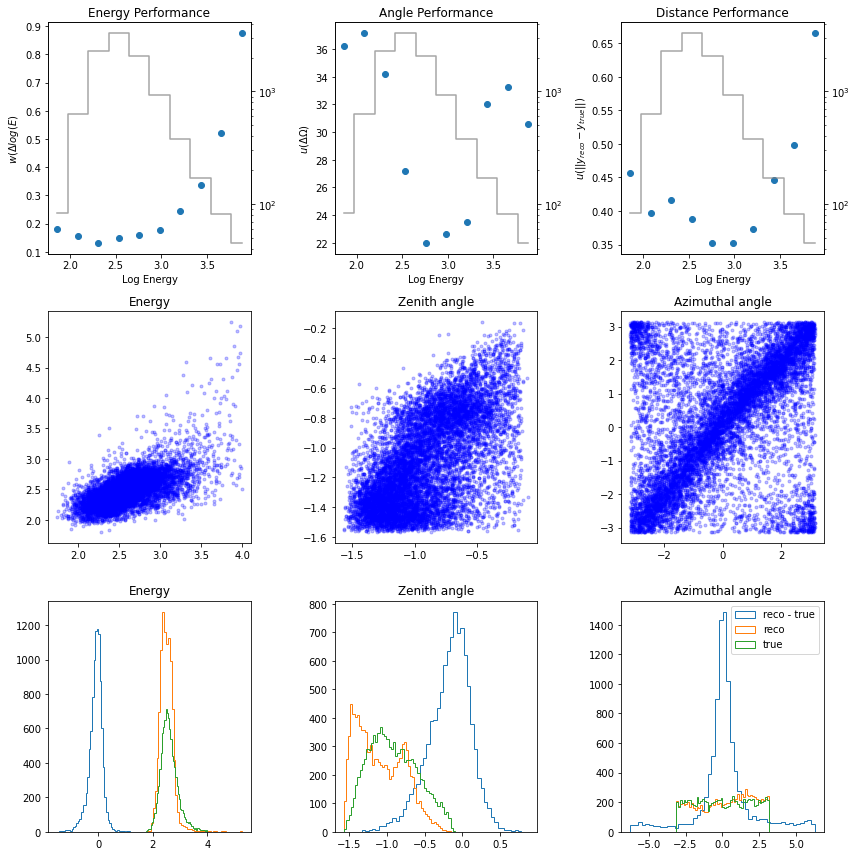

In [7]:
fig, ax = test(loader_test)